# Movie Sentiment Analysis: Simple Neural Network

In [1]:
import pandas as pd

movie_reviews = pd.read_csv("data/IMDB_Dataset.csv")

## Preprocess the data
* Remove HTML tags
* Remove non-alphabets
* Remove single characters
* Replace multiple spaces with single space

In [2]:
import re
import numpy as np

tag_re = re.compile(r'<[^>]+>')
def remove_tags(text):
    return tag_re.sub('', text)

def preprocess(sentence):
    pp_sentence = remove_tags(sentence)
    pp_sentence = re.sub('[^a-zA-Z]', ' ', pp_sentence)
    pp_sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', pp_sentence)
    pp_sentence = re.sub(r'\s+', ' ', pp_sentence)
    return pp_sentence

review_sentences = list(movie_reviews['review']) # list the reviews

X = []
for sentence in review_sentences:
    X.append(preprocess(sentence))
    
review_labels = list(map(lambda s: 1 if s=="positive" else 0, movie_reviews['sentiment'])) # list the sentiments

y = np.array(review_labels)

## Prepare training and testing data
* 80% training data
* 20% test data
* seed 42

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Prepare Embedding layer

### Preprocess for the embedding layer

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1 # +1 because of reserved 0 index
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Using TensorFlow backend.


### Create feature matrix using pretrained word embedding model
* GloVe: http://nlp.stanford.edu/data/glove.6B.zip

In [5]:
from numpy import asarray, zeros

glove_file = open('data/glove.6B.100d.txt', encoding="utf8")

embedding_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector = asarray(records[1:], dtype='float32')
    embedding_dictionary[word] = vector
    
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vector = embedding_dictionary.get(word)
    if vector is not None:
        embedding_matrix[index] = vector
        
print(embedding_matrix.shape)

(92547, 100)


# Text Classification model: Simple Neural Network
* **Sequential model**
* One **embedding layer**
    * Since we are not training our own embeddings and using the GloVe embedding, we set trainable to False and in the weights attribute we pass our own embedding matrix.
* **Flatten layer**
* **Dense layer**
    * Activation = sigmoid

### Create and train model

In [6]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

reviews_model = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 1s 24us/step - loss: 0.6011 - acc: 0.6720 - val_loss: 0.5332 - val_acc: 0.7368
Epoch 2/6
32000/32000 [==============================] - 1s 20us/step - loss: 0.4921 - acc: 0.7640 - val_loss: 0.5151 - val_acc: 0.7458
Epoch 3/6
32000/32000 [====================

### Evaluate the model

In [7]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0]*100, '%')
print("Test Accuracy:", score[1]*100, '%')

10000/10000 [==============================] - 0s 30us/step
Test Score: 54.85781580924988 %
Test Accuracy: 73.58999848365784 %


## Plot Accuracy and Loss

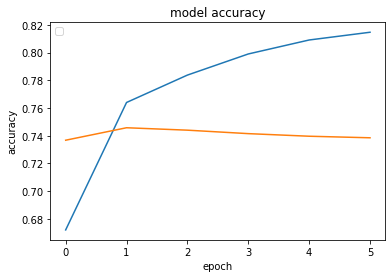

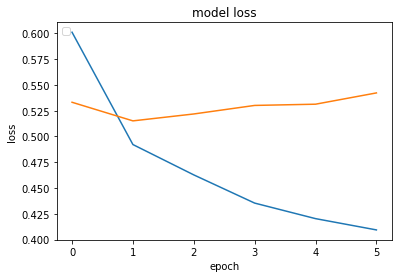

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')

plt.plot(reviews_model.history['acc'])
plt.plot(reviews_model.history['val_acc'])

plt.show()

plt.figure()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')

plt.plot(reviews_model.history['loss'])
plt.plot(reviews_model.history['val_loss'])

plt.show()

## Save the model

In [9]:
import pickle

filename = 'model_NN.sav'
pickle.dump(model, open(filename, 'wb'))